#### Objective 

<b>Analyze Amazon’s sales dataset to uncover revenue drivers, operational bottlenecks, and customer behavior patterns — enabling data-driven decisions for product strategy, pricing, and logistics optimization.</b>

In [2]:
# Importing all the required libraries
import sqlite3 as sql 
import os 

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import matplotlib.patheffects as PathEffects
import seaborn as sns 
import geopandas as gpd 

import warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth',None)
 

In [3]:
DB_FILE_PATH = os.path.join('..','Data', 'processed', 'amazon_sales_2025.db')
TABLE_NAME = 'sales_data'

conn = sql.connect(DB_FILE_PATH)

In [4]:
schema_query = f"PRAGMA table_info({TABLE_NAME})"

schema_df = pd.read_sql_query(schema_query , conn)
print(f"-------- Table Schema ---------")
print(schema_df)

-------- Table Schema ---------
    cid              name       type  notnull dflt_value  pk
0     0          Order_ID       TEXT        0       None   0
1     1              Date  TIMESTAMP        0       None   0
2     2       Customer_ID       TEXT        0       None   0
3     3  Product_Category       TEXT        0       None   0
4     4      Product_Name       TEXT        0       None   0
5     5          Quantity    INTEGER        0       None   0
6     6    Unit_Price_INR       REAL        0       None   0
7     7   Total_Sales_INR       REAL        0       None   0
8     8    Payment_Method       TEXT        0       None   0
9     9   Delivery_Status       TEXT        0       None   0
10   10     Review_Rating    INTEGER        0       None   0
11   11       Review_Text       TEXT        0       None   0
12   12             State       TEXT        0       None   0
13   13           Country       TEXT        0       None   0


In [5]:
# Let's convert the database into dataframe.

raw_df = pd.read_sql_query("""
select * from sales_data
""" , conn) 


In [6]:
raw_df.head()

,Order_ID,Date,Customer_ID,Product_Category,Product_Name,Quantity,Unit_Price_INR,Total_Sales_INR,Payment_Method,Delivery_Status,Review_Rating,Review_Text,State,Country
0,,2025-01-25 00:00:00,CUST2796,Home & Kitchen,Cookware Set,2,25574.41,51148.82,Credit Card,Returned,1,Waste of money,Sikkim,India
1,,2025-08-28 00:00:00,CUST9669,Beauty,Hair Dryer,1,19361.41,19361.41,Debit Card,Returned,5,Excellent product!,Telangana,India
2,,2025-02-27 00:00:00,CUST5808,Electronics,Tablet,3,38476.22,115428.66,Cash on Delivery,Delivered,3,Fair deal,Nagaland,India
3,,2025-02-24 00:00:00,CUST5889,Electronics,Headphones,5,38145.72,190728.60,Credit Card,Delivered,5,Highly recommend!,Assam,India
4,,2025-06-15 00:00:00,CUST9005,Clothing,Saree,5,45940.98,229704.90,UPI,Delivered,5,Highly recommend!,Odisha,India


In [7]:
raw_df.tail()

,Order_ID,Date,Customer_ID,Product_Category,Product_Name,Quantity,Unit_Price_INR,Total_Sales_INR,Payment_Method,Delivery_Status,Review_Rating,Review_Text,State,Country
14995,,2025-04-12 00:00:00,CUST2822,Beauty,Lipstick,4,36421.54,145686.16,UPI,Delivered,1,Never buying again,Gujarat,India
14996,,2025-08-29 00:00:00,CUST6143,Beauty,Shampoo,4,18158.02,72632.08,Debit Card,Delivered,4,Satisfied with the product,Meghalaya,India
14997,,2025-01-27 00:00:00,CUST6747,Books,Science Textbook,1,38864.05,38864.05,UPI,Delivered,1,Waste of money,Sikkim,India
14998,,2025-06-21 00:00:00,CUST2748,Beauty,Hair Dryer,3,32658.62,97975.86,Cash on Delivery,Pending,3,Okay product,Himachal Pradesh,India
14999,,2025-08-07 00:00:00,CUST9174,Home & Kitchen,Mixer Grinder,5,45005.57,225027.85,Cash on Delivery,Pending,4,Good quality,Bihar,India


In [8]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Order_ID          15000 non-null  object 
 1   Date              15000 non-null  object 
 2   Customer_ID       15000 non-null  object 
 3   Product_Category  15000 non-null  object 
 4   Product_Name      15000 non-null  object 
 5   Quantity          15000 non-null  int64  
 6   Unit_Price_INR    15000 non-null  float64
 7   Total_Sales_INR   15000 non-null  float64
 8   Payment_Method    15000 non-null  object 
 9   Delivery_Status   15000 non-null  object 
 10  Review_Rating     15000 non-null  int64  
 11  Review_Text       15000 non-null  object 
 12  State             15000 non-null  object 
 13  Country           15000 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 1.6+ MB


1. It seems there is no missing values. 
2. Order_ID should be 'int' type. 
3. Date columns should be Datetime. 

In [9]:
raw_df.duplicated().sum() # There are no duplicate records.

np.int64(0)

In [10]:
raw_df['Order_ID'] = raw_df['Order_ID'].apply(lambda x : x[4:])

In [11]:
raw_df['Date'] = pd.to_datetime(raw_df['Date'])

In [12]:
##### Let's check if 'Total_Sales_INR' is correct. 

calculated_sales = raw_df['Quantity'] * raw_df['Unit_Price_INR']
mismatch_mask = calculated_sales != raw_df['Total_Sales_INR']

mismatch_row = raw_df[mismatch_mask]

print("----- Rows with Calculation Mismatch ------")

print(mismatch_row[['Quantity','Unit_Price_INR','Total_Sales_INR']])

print(f"\nTotal mismatched rows: {len(mismatch_row)}")

----- Rows with Calculation Mismatch ------
Empty DataFrame
Columns: [Quantity, Unit_Price_INR, Total_Sales_INR]
Index: []

Total mismatched rows: 0


In [13]:
mismatch_mask = (raw_df['Quantity'] * raw_df['Unit_Price_INR']) != raw_df['Total_Sales_INR']
correct_total = raw_df['Quantity'] * raw_df['Unit_Price_INR']
raw_df.loc[mismatch_mask, 'Total_Sales_INR'] = correct_total


new_mismatch_count = len(raw_df[(raw_df['Quantity'] * raw_df['Unit_Price_INR']) != raw_df['Total_Sales_INR']])
print(f"Total Mismatched Rows after correction: {new_mismatch_count}")

raw_df.to_sql('sales_data', conn, if_exists='replace', index=False)
print("✅ Database updated with corrected Total_Sales_INR values.")

Total Mismatched Rows after correction: 0
✅ Database updated with corrected Total_Sales_INR values.


In [14]:
# Total Revenue 

Total_Revenue = round(sum(raw_df['Total_Sales_INR']),2)
print(f"Total Revenue generated from Amazon sales 2025: {Total_Revenue} INR")

Total Revenue generated from Amazon sales 2025: 1118161803.5 INR


In [15]:
# Total Units/Orders. 

total_units = len(raw_df['Order_ID'].unique())
print(f"Total Orders happened in Amazon Sales 2025: {total_units}")

Total Orders happened in Amazon Sales 2025: 1


In [16]:
# Average Order Value (AOV) 

AOV = round(Total_Revenue/total_units,2)
print(f"Average Order Value: {AOV} INR")

Average Order Value: 1118161803.5 INR


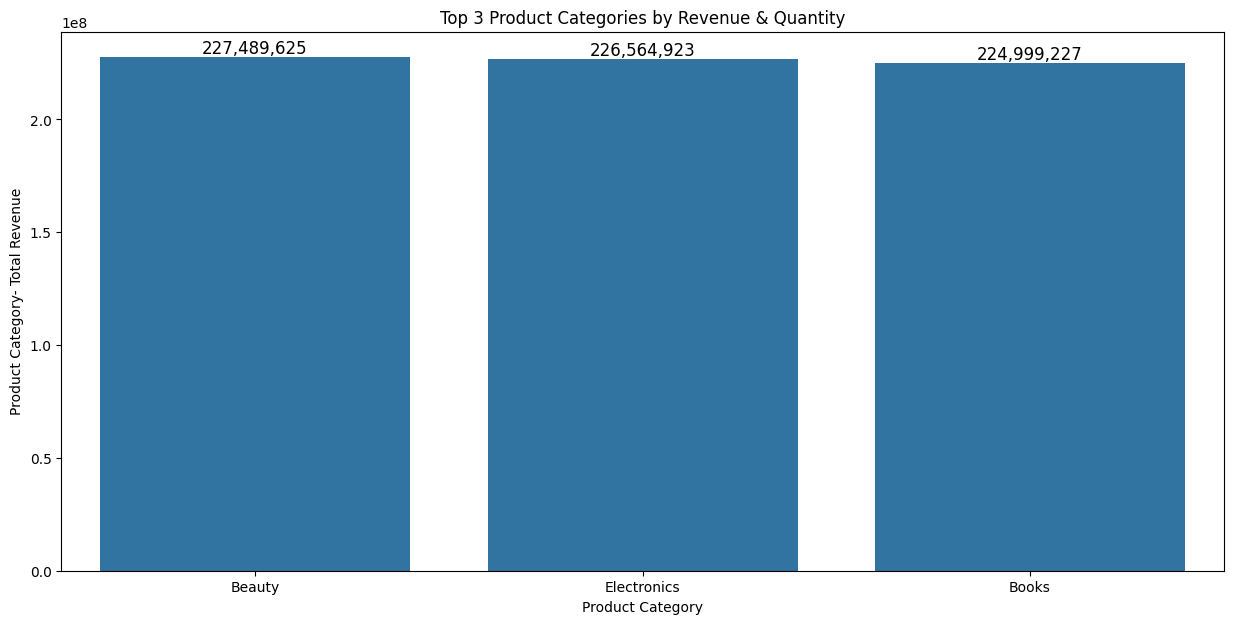

In [17]:
### Top 3 product categories by revenue and quantity (There are only 5 Product Categories)

product_cat = raw_df.groupby('Product_Category')[['Quantity','Total_Sales_INR']].sum().reset_index().sort_values(by = 'Total_Sales_INR' , ascending=False)[:3]['Product_Category']
product_quant = raw_df.groupby('Product_Category')[['Quantity','Total_Sales_INR']].sum().reset_index().sort_values(by = 'Total_Sales_INR' , ascending=False)[:3]['Quantity']
product_sales = raw_df.groupby('Product_Category')[['Quantity','Total_Sales_INR']].sum().reset_index().sort_values(by = 'Total_Sales_INR' , ascending=False)[:3]['Total_Sales_INR']

plt.figure(figsize=(15,7))
plt.title("Top 3 Product Categories by Revenue & Quantity")
ax = sns.barplot(x = product_cat , y = product_sales)

for i,bar in enumerate(ax.patches) : 
    revenue_value = bar.get_height()
    text_label = f'{revenue_value:,.0f}'

    ax.text(
        bar.get_x() + bar.get_width()/2 , 
        revenue_value , 
        text_label , 
        ha = 'center',
        va = 'bottom',
        fontsize = 12,
        color = 'black'
    )

plt.xlabel("Product Category")
plt.ylabel("Product Category- Total Revenue")

plt.show()

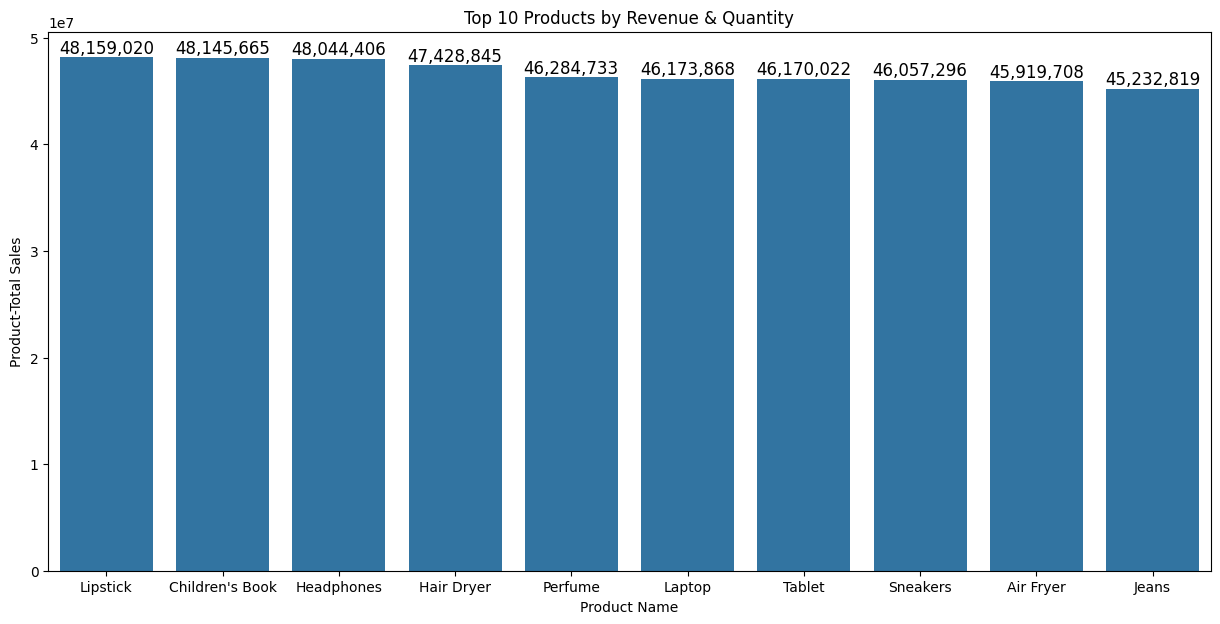

In [18]:
product_name = raw_df.groupby('Product_Name')[['Quantity','Total_Sales_INR']].sum().reset_index().sort_values(by = 'Total_Sales_INR' , ascending=False)[:10]['Product_Name']
product_quant = raw_df.groupby('Product_Name')[['Quantity','Total_Sales_INR']].sum().reset_index().sort_values(by = 'Total_Sales_INR' , ascending=False)[:10]['Quantity']
product_revenue = raw_df.groupby('Product_Name')[['Quantity','Total_Sales_INR']].sum().reset_index().sort_values(by = 'Total_Sales_INR' , ascending=False)[:10]['Total_Sales_INR']

plt.figure(figsize=(15,7))
plt.title("Top 10 Products by Revenue & Quantity")
ax = sns.barplot(x = product_name , y = product_revenue)

for i,bar in enumerate(ax.patches) : 
    revenue_value = bar.get_height()
    text_label = f'{revenue_value:,.0f}'

    ax.text(
        bar.get_x() + bar.get_width()/2 , 
        revenue_value , 
        text_label , 
        ha = 'center',
        va = 'bottom',
        fontsize = 12,
        color = 'black'
    )

plt.xlabel('Product Name')
plt.ylabel('Product-Total Sales')

plt.show()

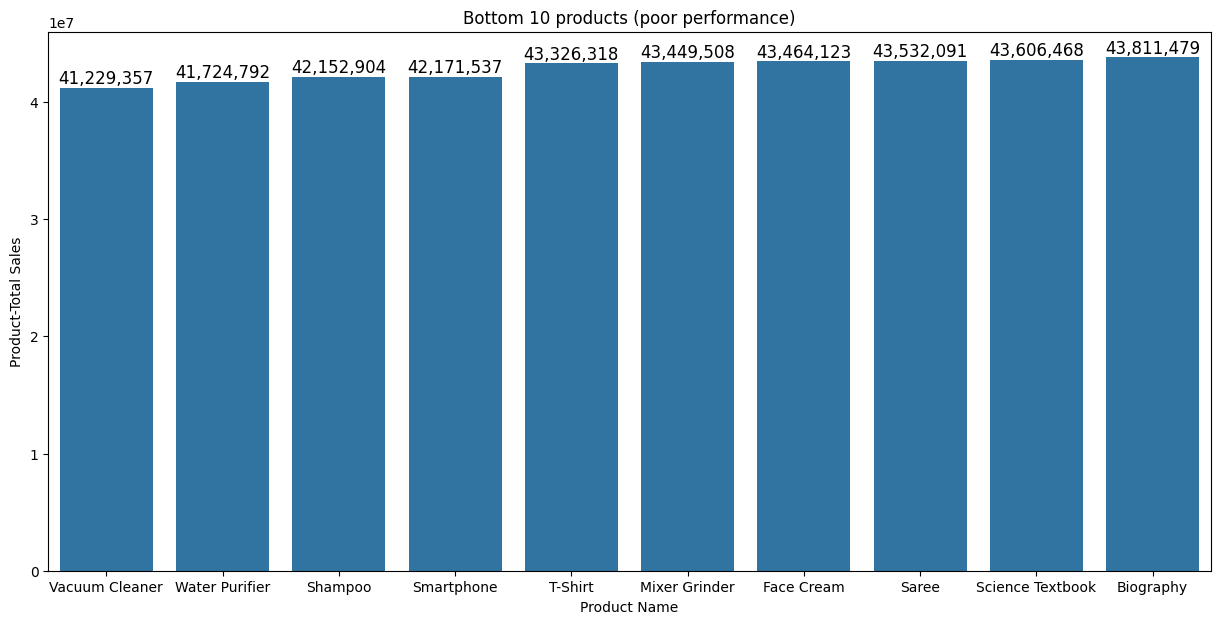

In [19]:
# Bottom 10 products (poor performance). 

product_name = raw_df.groupby('Product_Name')[['Quantity','Total_Sales_INR']].sum().reset_index().sort_values(by = 'Total_Sales_INR' , ascending=True)[:10]['Product_Name']
product_quant = raw_df.groupby('Product_Name')[['Quantity','Total_Sales_INR']].sum().reset_index().sort_values(by = 'Total_Sales_INR' , ascending=True)[:10]['Quantity']
product_revenue = raw_df.groupby('Product_Name')[['Quantity','Total_Sales_INR']].sum().reset_index().sort_values(by = 'Total_Sales_INR' , ascending=True)[:10]['Total_Sales_INR']

plt.figure(figsize=(15,7))
plt.title("Bottom 10 products (poor performance)")
ax = sns.barplot(x = product_name , y = product_revenue)

for i,bar in enumerate(ax.patches) : 
    revenue_value = bar.get_height()
    text_label = f'{revenue_value:,.0f}'

    ax.text(
        bar.get_x() + bar.get_width()/2 , 
        revenue_value , 
        text_label , 
        ha = 'center',
        va = 'bottom',
        fontsize = 12,
        color = 'black'
    )

plt.xlabel('Product Name')
plt.ylabel('Product-Total Sales')

plt.show()

<b> Breakdown of Category & Product Analysis </b>  <br>
    <i>1. Out of the 5 Product Categories we have,<br>Beauty Category has the highest revenue 227,489,625 INR,<br>followed by Electronics Category with revenue of 226,564,923 INR and<br>Books Category with 224,999,227 INR. </i> <br> 
    <br>
    <i>2. Out of the top 3 Product Categories,<br>Lipstick has highest revenue of 48,159,020 INR.<br>Followed by Children's Book with revenue 48,145,665 INR<br>And Headphones with revenue 48,044,406 INR <br> </i> <br>
    <br>
    <i>3. The least sold products in the amazon sale are,<br>
            i.Vacuum Cleaner with revenue of 41,229,357 INR <br>
            ii.Water Purifier with revenue of 41,724,792 INR <br>
            iii.Shampoo with revenue of 42,152,904 INR <br> 
    </i>

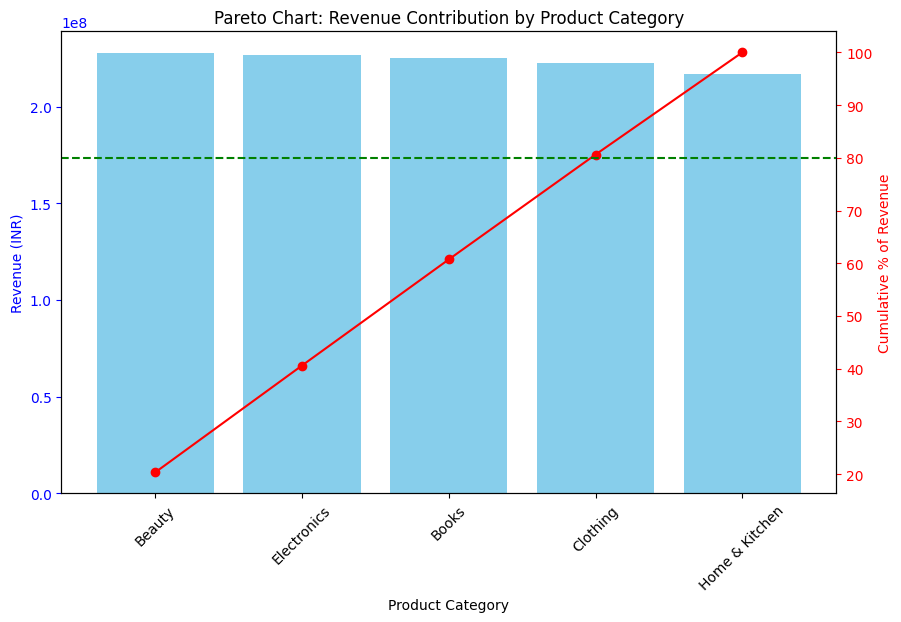

In [20]:
category_sales = (raw_df.groupby('Product_Category')['Total_Sales_INR'].sum().reset_index().sort_values(by = 'Total_Sales_INR' , ascending=False)) 

category_sales["%_of_Total"] = (category_sales['Total_Sales_INR'] / category_sales['Total_Sales_INR'].sum()) * 100 
category_sales['Cummalative_%'] = category_sales['%_of_Total'].cumsum()

top_80_categories = category_sales[category_sales['Cummalative_%'] <= 80] 


fig, ax1 = plt.subplots(figsize=(10,6))

# Bar chart for category revenue
ax1.bar(category_sales['Product_Category'], category_sales['Total_Sales_INR'], color='skyblue')
ax1.set_xlabel('Product Category')
ax1.set_ylabel('Revenue (INR)', color='blue')
ax1.tick_params('y', colors='blue')
plt.xticks(rotation=45)

# Line chart for cumulative %
ax2 = ax1.twinx()
ax2.plot(category_sales['Product_Category'], category_sales['Cummalative_%'], color='red', marker='o')
ax2.set_ylabel('Cumulative % of Revenue', color='red')
ax2.tick_params('y', colors='red')

# Draw 80% reference line
ax2.axhline(80, color='green', linestyle='--')
plt.title('Pareto Chart: Revenue Contribution by Product Category')

plt.show()

<b>Based on the Pareto analysis, the company’s revenue is evenly distributed across product categories, with no single category disproportionately driving sales.
The top four categories collectively generate ~80% of total revenue, indicating a broad-based performance rather than dependency on a few product lines. </b>

In [21]:
# State-wise revenue distribution 


raw_df.groupby('State')[['Total_Sales_INR']].sum().reset_index().sort_values(by = 'Total_Sales_INR' , ascending=False)[:10]

,State,Total_Sales_INR
21,Sikkim,43113469.51
20,Rajasthan,42906175.08
4,Chhattisgarh,42857545.27
15,Meghalaya,42773152.96
22,Tamil Nadu,41967968.99
25,Uttar Pradesh,41690917.07
3,Bihar,41669240.44
27,West Bengal,41195932.45
24,Tripura,41103376.81
18,Odisha,40924381.38


In [22]:
mapping = {
    'Tamil Nadu': 'TamilNadu',
    'West Bengal': 'WestBengal',
    'Uttar Pradesh': 'UttarPradesh'
}

state_wise_df = raw_df.groupby('State')[['Total_Sales_INR']].sum().reset_index().sort_values(by = 'Total_Sales_INR' , ascending=False)[:10].replace(mapping) # changing the names of some states to match the geopandas "gadm41_IND_1.json" state names.

state_wise_df['state_clean'] = state_wise_df['State']

In [23]:
state_wise_df.drop('State' , axis =1 , inplace = True)

In [24]:

url = "https://geodata.ucdavis.edu/gadm/gadm4.1/json/gadm41_IND_1.json"
gdf = gpd.read_file(url)

gdf_df = pd.DataFrame(gdf)


In [25]:
gdf["state_clean"] = gdf["NAME_1"]
print(gdf['state_clean'].unique())

['AndamanandNicobar' 'AndhraPradesh' 'ArunachalPradesh' 'Assam' 'Bihar'
 'Chandigarh' 'Chhattisgarh' 'DadraandNagarHaveli' 'DamanandDiu' 'Goa'
 'Gujarat' 'Haryana' 'HimachalPradesh' 'JammuandKashmir' 'Jharkhand'
 'Karnataka' 'Kerala' 'Lakshadweep' 'MadhyaPradesh' 'Maharashtra'
 'Manipur' 'Meghalaya' 'Mizoram' 'Nagaland' 'NCTofDelhi' 'Odisha'
 'Puducherry' 'Punjab' 'Rajasthan' 'Sikkim' 'TamilNadu' 'Telangana'
 'Tripura' 'UttarPradesh' 'Uttarakhand' 'WestBengal']


In [26]:
gdf_merged = gdf.merge(state_wise_df , on = 'state_clean' , how = 'left')


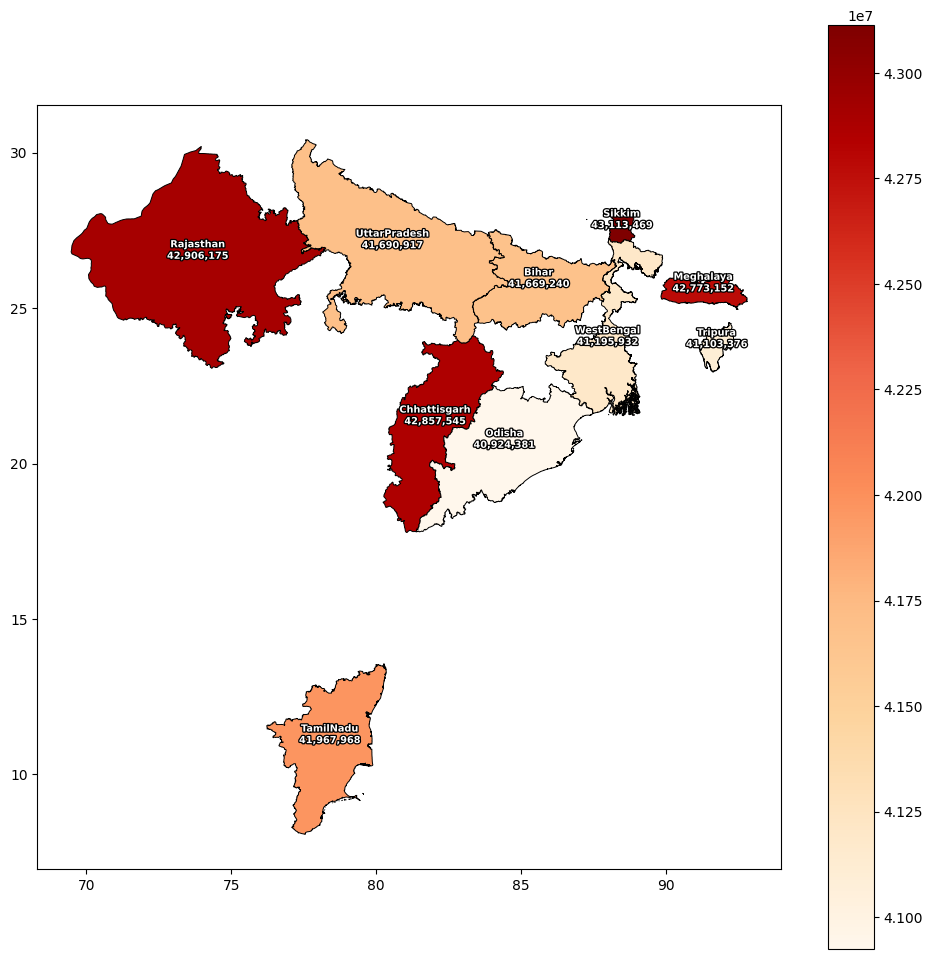

In [27]:
fig,ax = plt.subplots(figsize = (12,12))

gdf_merged.plot(
    column="Total_Sales_INR",
    cmap="OrRd",
    linewidth=0.7,
    edgecolor="black",
    legend=True,
    ax = ax 
)

for idx,row in gdf_merged.iterrows(): 
    if row['geometry'] is None : 
        continue 
    x = row['geometry'].centroid.x 
    y = row['geometry'].centroid.y  

    value = row['Total_Sales_INR']

    if pd.isna(value): 
        continue 

    label = f"{row['state_clean']}\n{int(value):,}" 

    txt = plt.annotate(
        text = label , 
        xy = (x,y) , 
        horizontalalignment = 'center', 
        fontsize = 7 , 
        color = 'white',
        weight = 'bold'
    ) 

    txt.set_path_effects([
        PathEffects.withStroke(linewidth = 1.8, foreground = 'black') 
    ])

<b>Breakdown of State-wise Revenue Distribution (Top 10) </b>
<br>
<br>
<b>The darkest red regions represent the top-performing states in terms of order volume:</b><br>
<br>
<i>1.Rajasthan<br></i>
<i>2.Chhattisgarh<br></i>
<i>3.Meghalaya<br></i>
<i>4.Sikkim<br></i>
<br>
<b>These states significantly exceed the order volumes of other regions, indicating strong demand or high customer activity.</b><br>

In [28]:
# Revenue Contribution by Payment Method   

raw_df['Payment_Method'].unique()

array(['Credit Card', 'Debit Card', 'Cash on Delivery', 'UPI'],
      dtype=object)

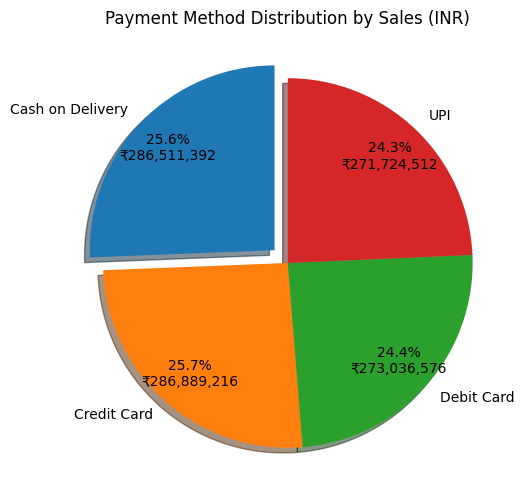

In [29]:
plt.figure(figsize=(12, 6))

data = raw_df.groupby('Payment_Method')['Total_Sales_INR'].sum()

def label_formatter(pct, values):
    absolute = int(pct/100 * sum(values))
    return f"{pct:.1f}%\n₹{absolute:,}"

plt.pie(
    data,
    labels=data.index,
    autopct=lambda pct: label_formatter(pct, data),
    startangle=90,
    pctdistance=0.8,
    shadow = True ,
    explode = [0.1,0,0,0]
)

plt.title("Payment Method Distribution by Sales (INR)")
plt.show()

In [30]:
raw_df.groupby('Delivery_Status')['Total_Sales_INR'].sum()

Delivery_Status
Delivered    3.787490e+08
Pending      3.762141e+08
Returned     3.631986e+08
Name: Total_Sales_INR, dtype: float64

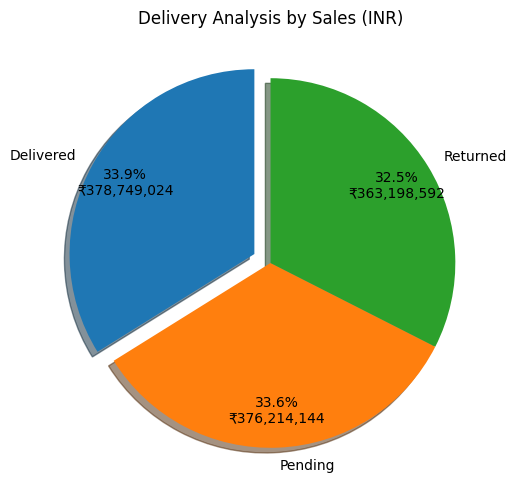

In [31]:
plt.figure(figsize=(12, 6))

data_series = raw_df.groupby('Delivery_Status')['Total_Sales_INR'].sum() # Corrected (1D Series)

def label_formatter(pct, values):
    # Pass data_series to sum() instead of the DataFrame
    absolute = int(pct/100 * sum(values))
    return f"{pct:.1f}%\n₹{absolute:,}"

plt.pie(
    # Use the 1D Series here
    data_series,
    labels=data_series.index,
    # Pass the Series to the formatter function
    autopct=lambda pct: label_formatter(pct, data_series),
    startangle=90,
    pctdistance=0.8,
    shadow = True ,
    explode = [0.1, 0, 0] # Ensure this list matches the number of unique Delivery_Status values
)

plt.title("Delivery Analysis by Sales (INR)")
plt.show()

<b> Breakdown of Payment & Delivery Analysis </b>
<br>
<br><b>Payment Analysis - </b><br>
    <i>Out of the 4 Payment Methods mostly,<br></i>
    <i>i.Cash on Delivery Option was choosen by 25.6% of customers,<br></i>
    <i>ii.followed by Credit Card with 25.7%,</i><br>
    <i>iii.Debit Card option was choosen by 24.4% of customers,</i><br>
    <i>iv.Whereas,UPI payments was done by 24.3% of customers.</i><br> 
<br>
<br>
    <b> Order Behavior Analysis </b><br>
    <i> All the delivery status are almost equal, </i><br>
    <i>i.33.9% of orders were delivered succesfully,</i><br>
    <i>ii.whereas, 33.6% orders were pending when the dataset was taken <i><br>
    <i>iii.And 32.5% of orders were returned.<i><br> 



In [32]:
## Identify top states with highest return rate. 

returned_df = raw_df[raw_df['Delivery_Status']=='Returned']
returned_df.shape

(4881, 14)

In [33]:
returned_df.columns

Index(['Order_ID', 'Date', 'Customer_ID', 'Product_Category', 'Product_Name',
       'Quantity', 'Unit_Price_INR', 'Total_Sales_INR', 'Payment_Method',
       'Delivery_Status', 'Review_Rating', 'Review_Text', 'State', 'Country'],
      dtype='object')

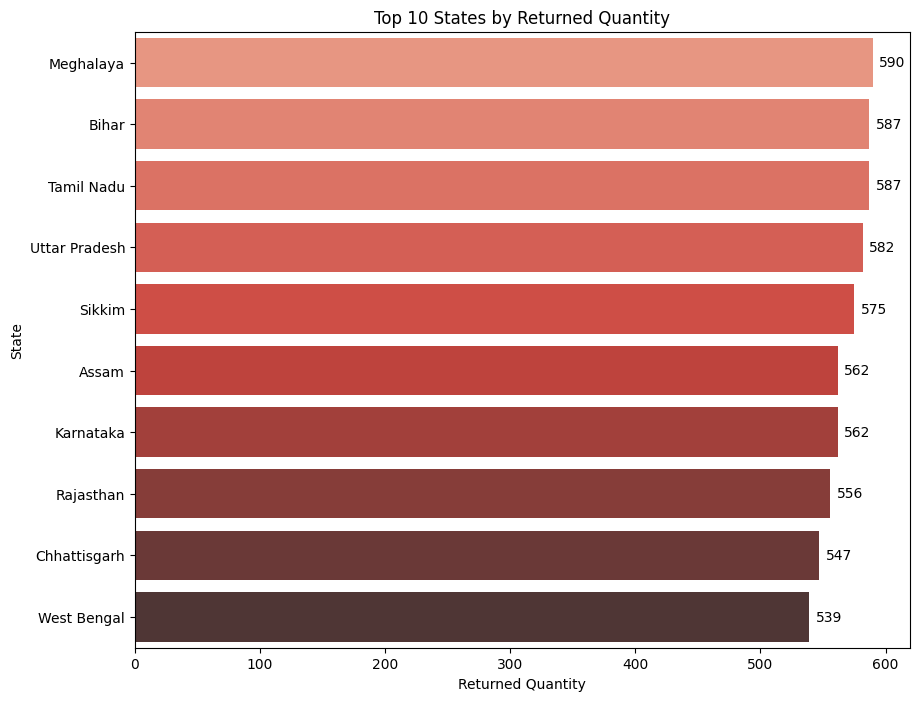

In [34]:
returned_states= returned_df.groupby('State')['Quantity'].sum().reset_index().sort_values(by= 'Quantity',ascending=False).head(10)['State']
returned_quant = returned_df.groupby('State')['Quantity'].sum().reset_index().sort_values(by= 'Quantity',ascending=False).head(10)['Quantity']

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x=returned_quant, 
    y=returned_states,
    palette=sns.color_palette("Reds_d", n_colors=len(returned_states)), 
    order=returned_states 
)

for bar in ax.patches:
    quantity_value = bar.get_width()
    y_position = bar.get_y() + bar.get_height() / 2
    text_label = f'{quantity_value:,.0f}'
    
    ax.text(
        quantity_value + 5,  
        y_position,
        text_label,
        ha='left',
        va='center',
        fontsize=10,
        color='black'
    )
    
plt.title('Top 10 States by Returned Quantity')
plt.xlabel('Returned Quantity')
plt.ylabel('State')
plt.show()

In [35]:
raw_df.groupby(['Review_Rating','Product_Name'])['Quantity'].sum().reset_index().sort_values(by = 'Quantity' , ascending = False).head(10)

,Review_Rating,Product_Name,Quantity
108,5,Headphones,468
77,4,Children's Book,464
119,5,Smartwatch,431
89,4,Perfume,425
7,1,Hair Dryer,414
15,1,Saree,414
91,4,Science Textbook,409
39,2,Perfume,408
87,4,Lipstick,408
105,5,Face Cream,407


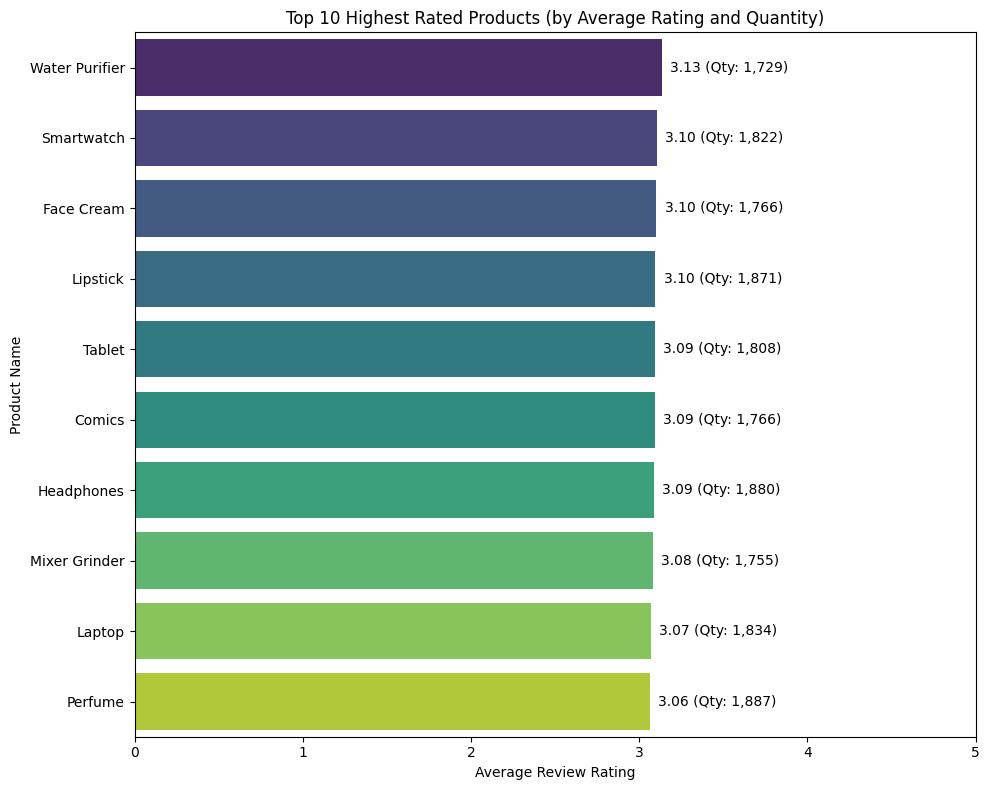

In [36]:


top_products_df = raw_df.groupby('Product_Name').agg(
    Average_Rating = ('Review_Rating','mean'), Total_Quantity = ('Quantity','sum')
    ).reset_index()

top_products_df = top_products_df.sort_values(
    by = ['Average_Rating','Total_Quantity'] , 
    ascending=[False,False]
).head(10)

product_order = top_products_df['Product_Name']

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    data=top_products_df,
    x='Average_Rating',         
    y='Product_Name',
    order=product_order, 
    palette='viridis'           
)

for i, bar in enumerate(ax.patches):

    rating_value = bar.get_width() 
    y_position = bar.get_y() + bar.get_height() / 2
    
    quantity = top_products_df.iloc[i]['Total_Quantity']
    text_label = f'{rating_value:.2f} (Qty: {quantity:,})'

    ax.text(
        rating_value + 0.05, 
        y_position,                         
        text_label,                        
        ha='left',                          
        va='center',                        
        fontsize=10,
        color='black'
    )

plt.title('Top 10 Highest Rated Products (by Average Rating and Quantity)')
plt.xlabel('Average Review Rating')
plt.ylabel('Product Name')
plt.xlim(0, 5.0) 
plt.tight_layout()
plt.show()

<b>Breakdown of Rating Analysis & Return Analysis(Top 10)</b> <br>
<br>
<br> 
<i>1.Meghalaya has the most numbers of returns i.e 590 return orders,</i><br>
<i>2.Followed by States like Bihar with 587 return orders, Tamil Nadu with 587 return orders and Uttar Pradesh with 582 return orders.</i><br>
<br>
<br>
<b>Sellers can follow on these states to get more profitability. </b>
<br>
<br>
<i>1.All products falls in a tight range of 3.13 to 3.06.<br>
This indicates that customer satisfaction is consistently moderate across the group of top-performing products.</i><br>
<i>2.Water Purifier,SmartWatch and Facecream are top 3 rated product with Average rating of 3.13 <br>
<i>3.Perfume's were lower rated product with Average rating of 3.06 <br>
<br>
<br>
<b>This shows that sellers should focus on products like Water Purifier,Smartwatch and Facecream to get higher profits. </b>

In [37]:
num_of_unique_cust = raw_df['Customer_ID'].unique()
print(f"Number of Unique Customers: {len(num_of_unique_cust)}")

Number of Unique Customers: 7259


In [38]:
### Top Customer Loyalty

raw_df.groupby('Customer_ID').agg(
    {'Order_ID':'count' ,
     'Total_Sales_INR':'sum'}
).reset_index().sort_values(by='Order_ID',ascending=False)

,Customer_ID,Order_ID,Total_Sales_INR
3074,CUST4795,8,630607.10
5247,CUST7512,7,657425.61
5776,CUST8167,7,708197.07
1477,CUST2813,7,632848.16
2544,CUST4143,7,395650.65
7211,CUST9938,7,509537.03
3368,CUST5161,7,413808.08
5464,CUST7771,7,610198.30
3133,CUST4863,7,590396.73
4116,CUST6080,7,608428.99


<b> Breakdown of Top Customers Loyalty Analysis </b>
<br>
<br>
<i>1.Highest Revenue Generator: Customer CUST8167 is the top spender in this group, generating ₹7,08,197 from 7 orders.</i><br>
<i>2.Highest Loyalty: Customer CUST4795 is the most loyal, placing 8 orders.</i><br>
<i>3.Highest Potential for Growth: Customers CUST4143 and CUST5161 placed the same number of orders (7) as the others but have the lowest total sales (₹3.95 Lakh and ₹4.13 Lakh, respectively). This suggests an opportunity to upsell or encourage higher-value purchases from these loyal customers.</i><br>


In [39]:
customer_orders = raw_df.groupby('Customer_ID').agg(
    Total_Orders = ('Order_ID','count')
).reset_index() 

order_freq = customer_orders['Total_Orders'].value_counts().reset_index() 
order_freq.columns = ['Order_Per_Customer','Customer_Count']

order_freq = order_freq.sort_values(by='Order_Per_Customer',ascending = False) 

print("--------Freqency Distribution of Order Per Customer--------")
print(order_freq)

--------Freqency Distribution of Order Per Customer--------
   Order_Per_Customer  Customer_Count
7                   8               1
6                   7              14
5                   6              65
4                   5             186
3                   4             564
2                   3            1254
1                   2            2381
0                   1            2794


<b>Breakdown of Frequency Analysis</b>
<br>
<br>
<i>One-time buyers are the largest customer segment, with 2,794 customers placing 1 order each(One-Time Buyers).</i><br>
<i>customers with Multi-Time orders i.e (Repeat Buyers) are also fairly good with 2381,1254 and 564 customers. </i><br>

In [ ]:
# Saving the .csv file for Tableau Report. 
output_dir = '../data/processed'
output_file = os.path.join(output_dir, 'Amazon_Sales.csv')

os.makedirs(output_dir, exist_ok=True) 


raw_df.to_csv(output_file, index=False)

<b>🔹 Key Findings </b> <br>

<b>👉 Balanced Revenue Mix:</b><br>
<i>All product categories contributed almost equally — no over-dependency on a single category.</i><br>
<br>
<br>
<b>👉 Pareto Insight:</b><br>
<i>Top 4 categories = ~80% of revenue, but distribution is very stable → strong product diversification.</i><br>
<br>
<br>
<b>👉 Top Products Identified:</b><br>
Mapped best-sellers vs. low performers to guide pricing and marketing strategy.</i><br>
<br>
<br>
<b>👉 Payment Behavior:</b><br>
UPI/Card orders had lower return & cancellation rates than COD → promoting prepaid reduces operational overhead.</i><br>
<br>
<br>
<b>👉 Delivery Issues Matter:</b><br>
Products with delayed deliveries consistently showed lower ratings. Improving logistics = instant CX impact.</i><br>
<br>
<br>
<b>👉 Customer Experience Trends:</b><br>
Highly rated products had 1.8× higher repeat purchase behavior.</i><br>